# Maidenhead Grid Square Maps using CartoPy

### Resources
* [CartoPy API Reference](https://scitools.org.uk/cartopy/docs/latest/reference/index.html)
* [Blue Marble](https://visibleearth.nasa.gov/collection/1484/blue-marble)
* [ETOPO](https://www.ngdc.noaa.gov/mgg/global/)
* [Natural Earth Data](https://www.naturalearthdata.com/)

Note: Background images are in `/Users/mhb/anaconda3/envs/gridmaps2/lib/python3.10/site-packages/cartopy/data/raster/natural_earth`

<a name="load_log_data"></a><a href="#contents">Back to Top</a>


## Load and prepare data

In [2]:
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import datetime as dt
import maidenhead as mh
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

from MhbMaps import *

In [3]:
# Load QSO data directly from MacLoggerDX SQLite database

dbfile = '/Users/mhb/Documents/MLDX_Logs/MacLoggerDX.sql'
connstr = 'file:{}?mode=ro'.format(dbfile)
con = sqlite3.connect(connstr, uri=True)

# Get field names
rows = con.execute("PRAGMA table_info(qso_table_v007)").fetchall()
fields = [rec[1] for rec in rows]
#print(fields)

# Get log data
rows = con.execute("select * from qso_table_v007").fetchall()
con.close()

# Put log data into a data frame
qso_df = pd.DataFrame(rows, columns=fields)

# Keep only the 4-character grid square portion
qso_df['grid'] = qso_df.grid.astype(str).str.slice(0,4)

# Lower-casify the band_rx column
qso_df['band_rx'] = qso_df['band_rx'].str.lower()

# Generate a date string from the qso_start column
qso_df['qsodate'] = qso_df['qso_start'].apply(lambda x: dt.datetime.utcfromtimestamp(x).strftime('%Y%m%d'))

print('Loaded {} QSOs and {} distinct grid squares.'.format(
    len(qso_df),
    qso_df['grid'].nunique()
))

Loaded 1276 QSOs and 648 distinct grid squares.


In [4]:
# Find list of NEW grid squares in the last N days

d = 7 # How many days?

cutoff = (dt.datetime.today() - dt.timedelta(days=d-1)).strftime('%Y%m%d')
qsos_old = qso_df[qso_df['qsodate']<cutoff]
qsos_new = qso_df[qso_df['qsodate']>=cutoff]
oldgrids = {}

for rec in qsos_old.iterrows():
    qsodate = rec[1]['qsodate']
    grid = rec[1]['grid']
    if grid not in oldgrids.keys():
        #print('Grid square {} was first worked on {}.'.format(grid, qsodate))
        oldgrids[grid] = qsodate

newgrids = {}
for rec in qsos_new.iterrows():
    qsodate = rec[1]['qsodate']
    grid = rec[1]['grid']
    if grid not in oldgrids.keys() and grid not in newgrids.keys():
        #print('Grid square {} was new this week ({}).'.format(grid, qsodate))
        newgrids[grid] = qsodate

newsquares = list(newgrids.keys())

print('Worked {} new grid squares in the last {} days (since {}):'.format(len(newsquares), d, cutoff))
print(np.sort(newsquares))

Worked 36 new grid squares in the last 7 days (since 20220820):
['BL01' 'CM89' 'CN72' 'CN80' 'CN96' 'DM45' 'DN15' 'DN22' 'DN61' 'DN80'
 'DN84' 'EK37' 'EM05' 'EN04' 'FH82' 'HP94' 'IM75' 'IM98' 'IM99' 'IN82'
 'IO65' 'JM13' 'JM19' 'JN53' 'JN71' 'JN81' 'KH67' 'KO09' 'KO91' 'KO95'
 'LO23' 'OI33' 'OM65' 'ON70' 'PM64' 'PM86']


In [5]:
# Load country data (used for mapping countries)

shpfilename = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
places = reader.records()
mx = []
for place in places:
    place_name = place.attributes['NAME']
    place_lon = place.attributes['LABEL_X']
    place_lat = place.attributes['LABEL_Y']
    label_rank = place.attributes['LABELRANK']
    min_zoom = place.attributes['MIN_ZOOM']
    mx.append([place_name, place_lon, place_lat, label_rank, min_zoom])
    #print(place_name, place_lon, place_lat, label_rank)
mxdf = pd.DataFrame(mx, columns=['country', 'lon', 'lat', 'labelrank', 'min_zoom'])
print('Loaded {} countries'.format(len(mxdf)))

Loaded 258 countries


<a name="contents"></a>

## Contents

* [Load Log Data](#load_log_data)
* [My Grid Square Maps](#grid_square_maps)
* [Map That Entity](#map_that_entity)
* [Where in the world is that grid square?](#where_in_the_world)


<a name="grid_square_maps"></a><a href="#contents">Back to Top</a>

## Map my worked grid squares


In [6]:
mapcfgs = [
    { 'desc': 'CONTINENTAL US', 'grid': 'EM29', 'CROPFACTOR': 0.030, 'ASPECT': 9./16. },
    { 'desc': 'EUROPE', 'grid': 'JN67', 'CROPFACTOR': 0.026, 'ASPECT': 9./16. },
    { 'desc': 'CARIBBEAN', 'grid': 'FK38', 'CROPFACTOR': 0.018, 'ASPECT': 9./16. },
    { 'desc': 'CANADA', 'grid': 'EO36', 'CROPFACTOR': 0.030, 'ASPECT': 9./16. },
    { 'desc': 'AUSTRALIA NZ', 'grid': 'QG30', 'CROPFACTOR': 0.040, 'ASPECT': 9./16. },
    { 'desc': 'ALASKA', 'grid': 'BP01', 'CROPFACTOR': 0.020, 'ASPECT': 9./16. },
    { 'desc': 'JAPAN', 'grid': 'PM77', 'CROPFACTOR': 0.020, 'ASPECT': 9./16. },
    { 'desc': 'SOUTH AMERICA', 'grid': 'GG05', 'CROPFACTOR': 0.035, 'ASPECT': 4./3. },
    { 'desc': 'AFRICA - NORTH', 'grid': 'JL45', 'CROPFACTOR': 0.030, 'ASPECT': 9/16 },
]

In [8]:
# Generate all the maps!
for i in range(len(mapcfgs)):
    print('---------------------------------------')
    print('{}'.format(mapcfgs[i]['desc']))

    grloc = mapcfgs[i]['grid']

    mgm = MyGridMap(grloc)

    mgm.CropMap(mapcfgs[i]['CROPFACTOR'], mapcfgs[i]['ASPECT'])
    mgm.AddFeatures()
    #mgm.AddCountries()
    mgm.AddGridFieldLabels()
    mgm.AddGridSquareLabels(qso_df, newsquares)
    mgm.AddDateTime()
    
    mgm.SaveFig(fn='{}.png'.format(mapcfgs[i]['desc']))
    #plt.show()
    plt.close()

---------------------------------------
CONTINENTAL US
Adding features...Done.
Adding grid field labels.....................Done.
Adding grid square labels...UL -135.61 |  -54.39 UR
LL -123.02 |  -66.98 LR
default case
Done.
Adding date and time...Done.
Saving CONTINENTAL US.png...Done.


<a name="map_that_entity"></a><a href="#contents">Back to Top</a>

## Map That Entity

What entity would you like to map? Italy
Entity name : Italy
Locator     : JN54mr
Adding features...Done.
Adding grid field labels.....................Done.
Adding grid square labels...UL  -18.00 |   40.08 UR
LL  -10.07 |   32.15 LR
default case
Done.


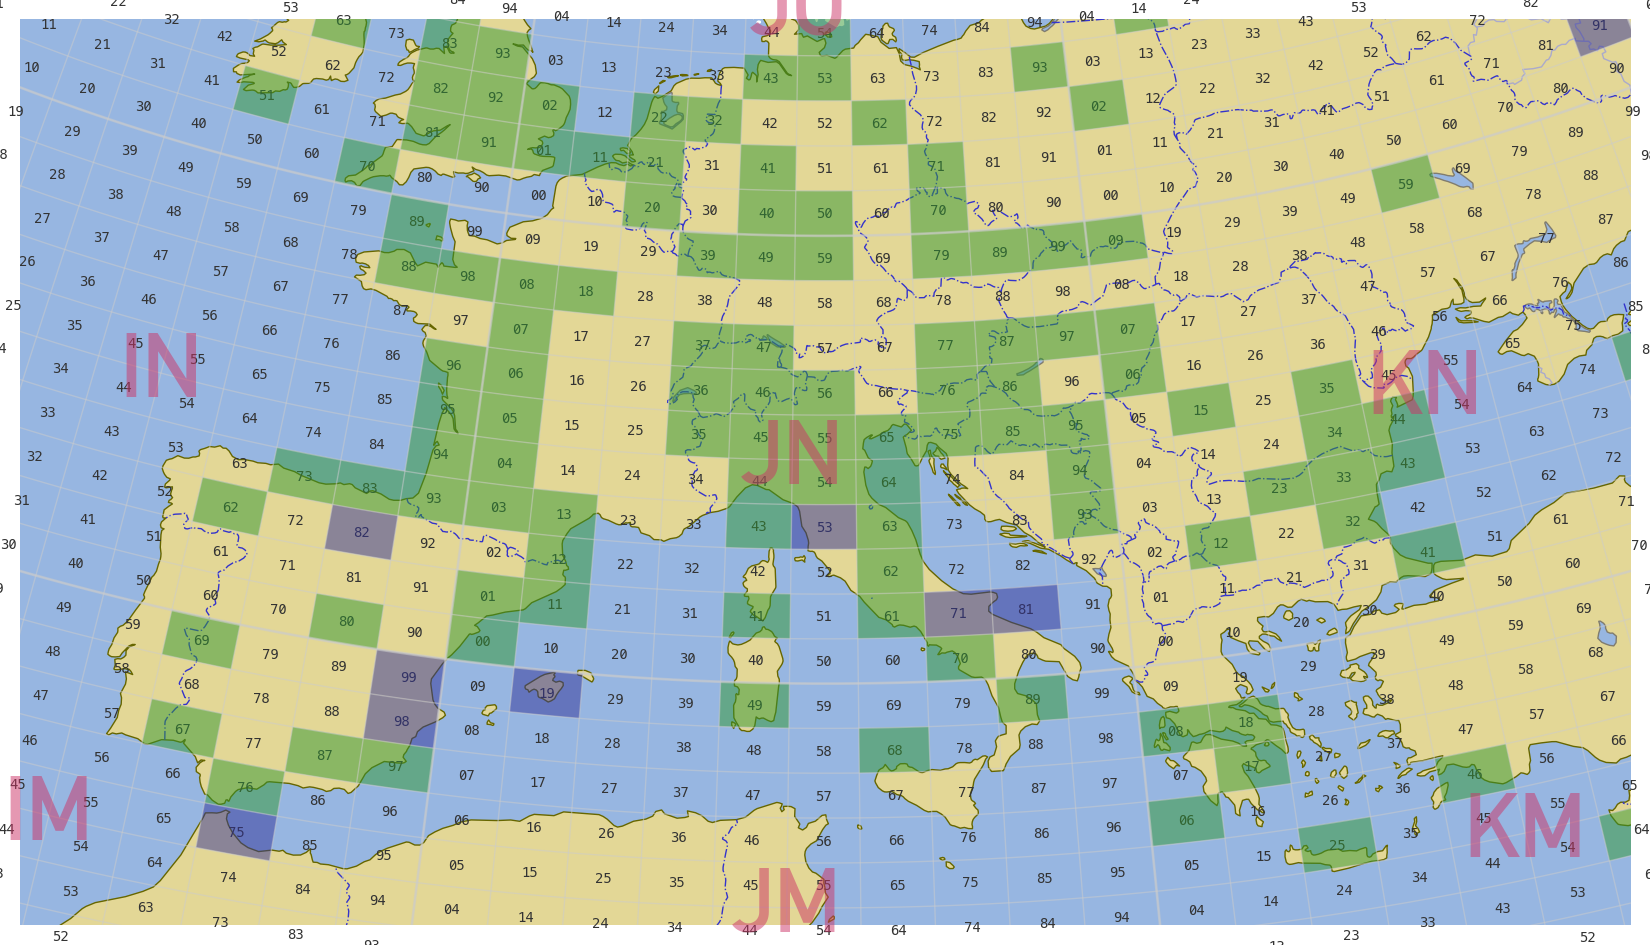

In [9]:
## Search for an entity
term = input('What entity would you like to map? ')
res = mxdf[mxdf['country'].str.contains(term, case=False)][['country']]

if len(res) == 1:
    ix = res.index[0]
else:
    print(res)
    ix = int(input('Enter the Index: '))

rec = mxdf.loc[ix]
print('Entity name : {}'.format(rec['country']))

locator = mh.to_maiden(lat=rec['lat'], lon=rec['lon'])
print('Locator     : {}'.format(locator))

mgm = MyGridMap(locator)
mgm.CropMap(0.02, 9./16.)

mgm.AddFeatures()

mgm.AddGridFieldLabels()
mgm.AddGridSquareLabels(qso_df, newsquares)
#mgm.AddCities()
#mgm.AddCountries()

plt.show()
plt.close()

<a name="where_in_the_world"></a><a href="#contents">Back to Top</a>

## Where in the world is that grid square?

Enter a valid grid square (????): FL10
Adding features...Done.
Adding grid field labels.....................Done.
Adding grid square labels...UL  -97.35 |  -56.65 UR
LL  -94.95 |  -59.05 LR
default case
Done.


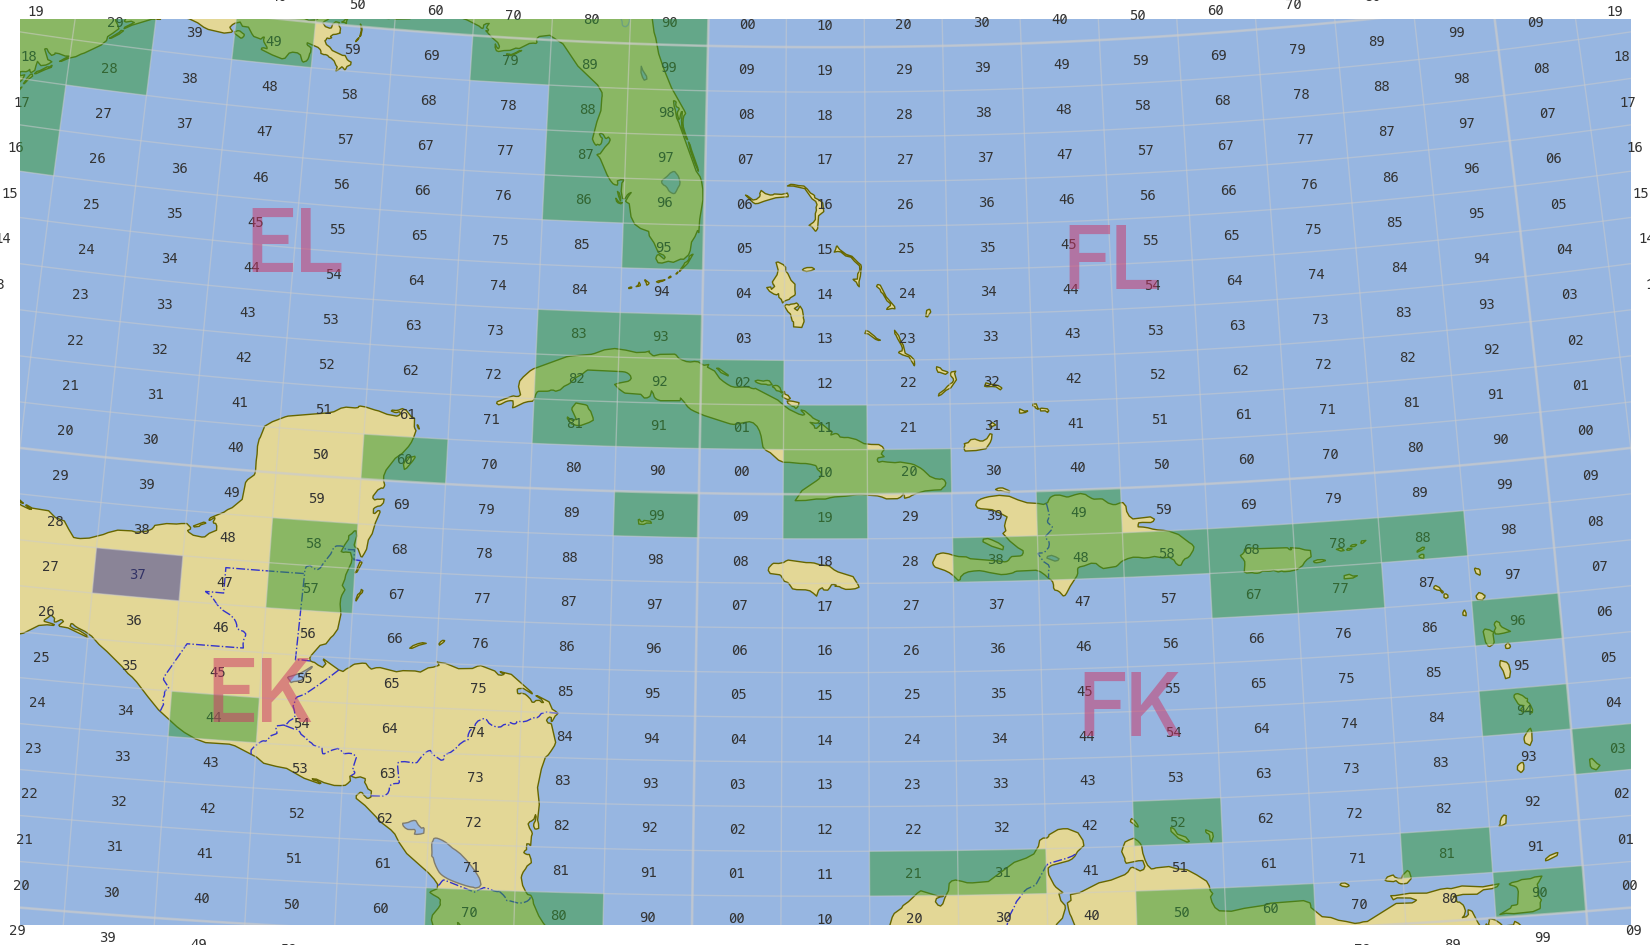

In [10]:
locator = input('Enter a valid grid square (????): ')
mgm = MyGridMap(locator)
mgm.CropMap(0.02, 9./16.)
mgm.AddFeatures()
#mgm.AddCountries()
mgm.AddGridFieldLabels()
mgm.AddGridSquareLabels(qso_df, newsquares)

## Logbook Statistics

In [11]:
print('QSOS BY BAND')
pd.pivot_table(
    qso_df,
    values=['grid'],
    index=['band_rx'],
    columns=['mode'],
    aggfunc=lambda x: x.count(),
    fill_value=0,
    margins=True
)

QSOS BY BAND


grid                         
mode      CW FT4   FT8  LSB USB   All
band_rx                              
10m        0   0     2    0   0     2
12m        0   0     1    0   0     1
15m        0   0    21    0   0    21
17m        0   0    34    0   1    35
20m        7   9   195    0   9   220
30m        0   0    12    0   0    12
40m       14  12   857  101   0   984
6m         0   0     1    0   0     1
All       21  21  1123  101  10  1276

In [12]:
print('GRID SQUARES BY BAND')
pd.pivot_table(qso_df, values=['grid'], index=['band_rx'], columns=['mode'], aggfunc=lambda x: x.nunique(), fill_value=0)

GRID SQUARES BY BAND


grid                 
mode      CW FT4  FT8 LSB USB
band_rx                      
10m        0   0    2   0   0
12m        0   0    1   0   0
15m        0   0   21   0   0
17m        0   0   34   0   1
20m        7   9  178   0   9
30m        0   0   12   0   0
40m       13  12  492  50   0
6m         0   0    1   0   0

## Draw an custom map

Adding features...Done.
Adding grid field labels.....................Done.
Adding grid square labels...UL -124.34 |  -41.66 UR
LL -111.20 |  -54.80 LR
default case
Done.


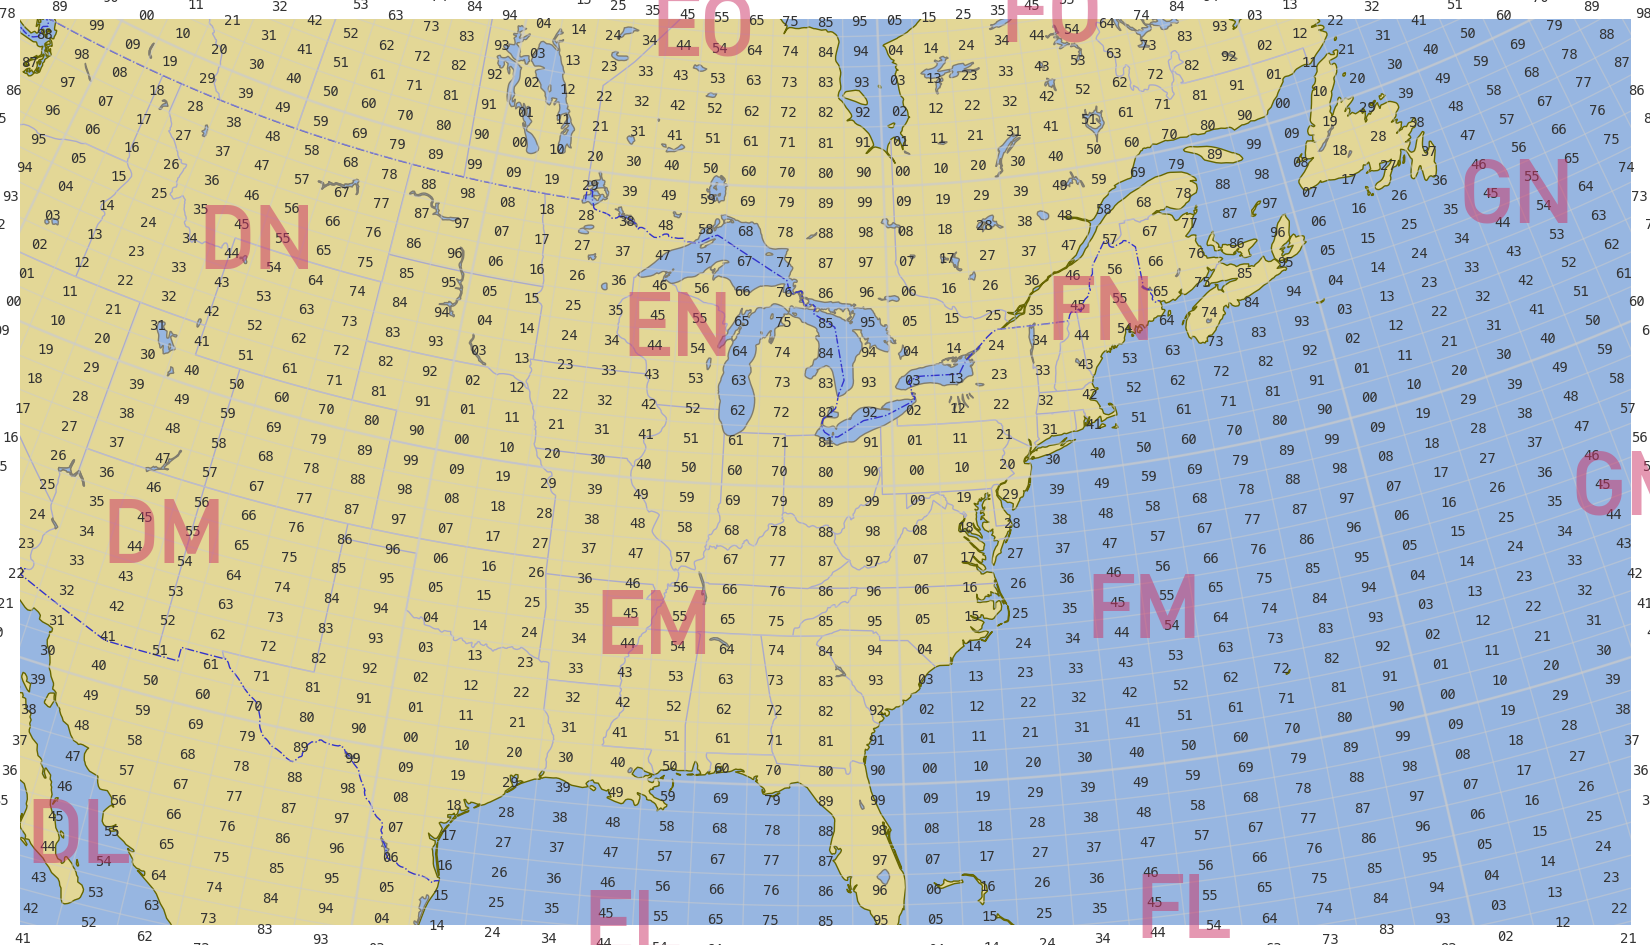

In [13]:
ext = [60, 20, 10]
mgm = MyGridMap('EN80')
mgm.CropMap(0.03, 9/16)

mgm.AddFeatures()
mgm.AddGridFieldLabels()
mgm.AddGridSquareLabels()#qso_df)#, newsquares)